In [306]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
import pathlib
import common

In [403]:
fig_dir = '/data/zhenyus/webcachesim/notebook/figures/'
n_csizes = 8

In [390]:
trace_cache_sizes = {
    'traceHK.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'traceUS.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'wc400m.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'memc_200m.tr':{
        67108864,
        134217728,
        268435456,
        536870912,
        1073741824,
        2147483648,
        4294967296,
        8589934592,
    },
    'msr_rehash_200m.tr':{
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'anonymous_200m.tr': {
        268435456,
        536870912,
        1073741824,
        2147483648,
        4294967296,
        8589934592,
        17179869184,
        34359738368,
    },
}

In [391]:
color_map = {
    'Belady': 'k',
#     'BeladySample': '#000080',
    'GDBT': 'b',
#     'LR': 'r',
    'LRUK': 'g',
    'FIFO': 'r',
    'LFUDA': '#808080',
#     'GDSF': 'm',
    'LRU': 'm',
    'LFU': '#808080',
    'S4LRU': 'r',
    'LHD': 'r',
#     'Hyperbolic': 'chartreuse',
    'LeCaR': '#ed740b',
#     'AdaptSize': '#669999',

#     'GDWheel': '#000080',
    'Adaptive-TinyLFU': 'burlywood',
}

In [392]:
trace_map = {
    'wc200m.tr': 'Wiki',
    'wc400m.tr': 'Wiki',
    'traceHK.tr': 'CDN-A',
    'traceUS.tr': 'CDN-E',
    'memc_200m.tr': 'Memc',
    'msr_rehash_200m.tr': 'MSR',
    'anonymous_200m.tr': 'A-App',
    'caida_cache_200m.tr': 'Caida',
}

In [269]:
# find top algorithms
df = common.load_reports()

In [406]:
filter_idx = ((
    (df.trace_file == 'traceHK.tr') 
    & (df.uni_size == 0)
    & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR'])) 
    & (df.cache_size.isin(trace_cache_sizes['traceHK.tr']))
    & (df.n_warmup == 80000000)
) | ((df.trace_file == 'traceUS.tr') 
    & (df.uni_size == 0)
    & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR'])) 
    & (df.cache_size.isin(trace_cache_sizes['traceUS.tr']))
    & (df.n_warmup == 100000000)
) | (
    (df.trace_file == 'wc400m.tr') 
    & (df.uni_size == 0)
    & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR'])) 
    & (df.cache_size.isin(trace_cache_sizes['wc400m.tr']))
    & (df.n_warmup == 80000000)
) | (
    (df.trace_file == 'memc_200m.tr') 
    & (df.uni_size == 0)
     & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR'])) 
    & (df.cache_size.isin(trace_cache_sizes['memc_200m.tr']))
    & (df.n_warmup == 20000000)
)| (
    (df.trace_file == 'msr_rehash_200m.tr') 
    & (df.uni_size == 0)
     & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR'])) 
    & (df.cache_size.isin(trace_cache_sizes['msr_rehash_200m.tr']))
    & (df.n_warmup == 100000000)
) | (
    (df.trace_file == 'anonymous_200m.tr') 
    & (df.uni_size == 0)
     & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR'])) 
    & (df.cache_size.isin(trace_cache_sizes['anonymous_200m.tr']))
    & (df.n_warmup == 20000000)
)
#     | (
#     (df.trace_file == 'caida_cache_200m.tr') 
#     & (df.uni_size == 0)
#      & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR'])) 
#     & (df.cache_size.isin(trace_cache_sizes['caida_cache_200m.tr']))
#     & (df.n_warmup == 20000000)
# )
)


df1 = df[filter_idx].copy()

In [407]:
res = []
for l, grp in df1.groupby(['trace_file', 'cache_size']):
    df2 = grp[grp['byte_hit_rate'] == grp.groupby('cache_type')['byte_hit_rate'].transform(max)]
    df2 = df2.groupby('cache_type').first().reset_index().sort_values('byte_hit_rate', ascending=False).reset_index(drop=True)
    res.append({
        'Belady': 1-df2[df2.cache_type == 'Belady'].byte_hit_rate.values[0],
        'GDBT': 1-df2[df2.cache_type == 'GDBT'].byte_hit_rate.values[0],
        'SOA': 1-df2[~df2.cache_type.isin(['Belady', 'GDBT'])].byte_hit_rate.values[0],
        'LRU': 1-df2[df2.cache_type == 'LRU'].byte_hit_rate.values[0],
        'TLFU': 1-df2[df2.cache_type == 'Adaptive-TinyLFU'].byte_hit_rate.values[0],
        'LFUDA': 1-df2[df2.cache_type == 'LFUDA'].byte_hit_rate.values[0],
        'type': 'cdn' if l[0] in ['traceHK.tr', 'traceUS.tr', 'wc400m.tr'] else 'nocdn',
        'SOA_alg': df2[~df2.cache_type.isin(['Belady', 'GDBT'])].cache_type.values[0],
        'trace_file': l[0],
        'cache_size': l[1],
#         'label': l
    })

In [408]:
df2 = pd.DataFrame(res)
df2['miss_reduction'] = (df2['SOA'] - df2['GDBT'])/df2['SOA']
df2['lru_reduction'] = (df2['LRU'] - df2['GDBT'])/df2['LRU']
df2['tlfu_reduction'] = (df2['LRU'] - df2['TLFU'])/df2['LRU']
df2['lfuda_reduction'] = (df2['LRU'] - df2['LFUDA'])/df2['LRU']

df2.head()

,Belady,GDBT,LFUDA,LRU,SOA,SOA_alg,TLFU,cache_size,trace_file,type,miss_reduction,lru_reduction,tlfu_reduction,lfuda_reduction
0,0.190569,0.272212,0.279852,0.293774,0.279852,LFUDA,0.289003,2.684355e+08,anonymous_200m.tr,nocdn,0.027300,0.073397,0.016241,0.047390
1,0.146875,0.215228,0.237805,0.246392,0.237805,LFUDA,0.241544,5.368709e+08,anonymous_200m.tr,nocdn,0.094939,0.126481,0.019674,0.034851
2,0.105677,0.158112,0.186179,0.187317,0.182793,Adaptive-TinyLFU,0.182793,1.073742e+09,anonymous_200m.tr,nocdn,0.135022,0.155912,0.024151,0.006075
3,0.069006,0.102502,0.130078,0.123786,0.121022,Adaptive-TinyLFU,0.121022,2.147484e+09,anonymous_200m.tr,nocdn,0.153027,0.171942,0.022332,-0.050830
4,0.044537,0.070210,0.084079,0.083813,0.083813,LRU,0.083879,4.294967e+09,anonymous_200m.tr,nocdn,0.162302,0.162302,-0.000793,-0.003174


In [441]:
df2.groupby('SOA_alg').count()

,Belady,GDBT,LFUDA,LRU,SOA,TLFU,cache_size,trace_file,type,miss_reduction,lru_reduction,tlfu_reduction,lfuda_reduction
SOA_alg,,,,,,,,,,,,,
Adaptive-TinyLFU,22,22,22,22,22,22,22,22,22,22,22,22,22
LFUDA,12,12,12,12,12,12,12,12,12,12,12,12,12
LHD,2,2,2,2,2,2,2,2,2,2,2,2,2
LRU,1,1,1,1,1,1,1,1,1,1,1,1,1
LRUK,5,5,5,5,5,5,5,5,5,5,5,5,5
LeCaR,5,5,5,5,5,5,5,5,5,5,5,5,5
S4LRU,1,1,1,1,1,1,1,1,1,1,1,1,1


In [440]:
df2[(df2.type == 'cdn')].groupby('SOA_alg').count()

,Belady,GDBT,LFUDA,LRU,SOA,TLFU,cache_size,trace_file,type,miss_reduction,lru_reduction,tlfu_reduction,lfuda_reduction
SOA_alg,,,,,,,,,,,,,
Adaptive-TinyLFU,12,12,12,12,12,12,12,12,12,12,12,12,12
LFUDA,5,5,5,5,5,5,5,5,5,5,5,5,5
LRUK,3,3,3,3,3,3,3,3,3,3,3,3,3
LeCaR,3,3,3,3,3,3,3,3,3,3,3,3,3
S4LRU,1,1,1,1,1,1,1,1,1,1,1,1,1


In [444]:
(df2['lfuda_reduction']<0).sum()

11

In [445]:
df2['lfuda_reduction'].min()

-0.20794744911314147

In [426]:
((df2.type == 'nocdn') & (df2.GDBT <= df2.SOA)).sum()

18

In [432]:
df2[df2.type == 'nocdn'].lru_reduction.median()

0.1008917654489101

In [433]:
df2[df2.type == 'nocdn'].lru_reduction.max()

0.3410090472449236

In [438]:
df2[df2.type == 'nocdn'].tlfu_reduction.median()

0.02100319464377773

In [439]:
df2[df2.type == 'nocdn'].tlfu_reduction

0     0.016241
1     0.019674
2     0.024151
3     0.022332
4    -0.000793
5     0.003815
6     0.012461
7     0.018689
8     0.032076
9     0.030994
10    0.088743
11    0.040796
12    0.060255
13    0.036166
14    0.036585
15   -0.044057
16    0.010176
17   -0.002466
18   -0.003606
19    0.013882
20    0.016578
21    0.135007
22    0.178256
23    0.100328
Name: tlfu_reduction, dtype: float64

In [435]:
df2[df2.type == 'nocdn'].tlfu_reduction.median()

0.02100319464377773

In [436]:
df2[df2.type == 'nocdn'].lfuda_reduction.median()

0.0069637857110050015

In [428]:
df2[((df2.type == 'nocdn') & (df2.GDBT > df2.SOA))]

,Belady,GDBT,LFUDA,LRU,SOA,SOA_alg,TLFU,cache_size,trace_file,type,miss_reduction,lru_reduction,tlfu_reduction,lfuda_reduction
7,0.011479,0.019541,0.018942,0.020113,0.018942,LFUDA,0.019737,3.435974e+10,anonymous_200m.tr,nocdn,-0.031623,0.028439,0.018689,0.058221
15,0.034083,0.044909,0.044971,0.042991,0.042971,LeCaR,0.044885,8.589935e+09,memc_200m.tr,nocdn,-0.045100,-0.044614,-0.044057,-0.046056
16,0.522709,0.556659,0.556010,0.561984,0.556010,LFUDA,0.556265,4.294967e+09,msr_rehash_200m.tr,nocdn,-0.001167,0.009475,0.010176,0.010630
17,0.513634,0.549975,0.548099,0.548221,0.546594,LRUK,0.549573,8.589935e+09,msr_rehash_200m.tr,nocdn,-0.006186,-0.003199,-0.002466,0.000223
18,0.500530,0.541961,0.539889,0.542648,0.537352,LRUK,0.544605,1.717987e+10,msr_rehash_200m.tr,nocdn,-0.008577,0.001266,-0.003606,0.005084
23,0.123719,0.243799,0.293503,0.303603,0.232490,LHD,0.273143,5.497558e+11,msr_rehash_200m.tr,nocdn,-0.048643,0.196981,0.100328,0.033267


In [422]:
df2[(df2.type == 'cdn')].lru_reduction.median()

0.09305370933628807

In [423]:
df2[(df2.type == 'cdn')].tlfu_reduction.median()

0.04174040074332141

In [410]:
len(df2)

48

In [418]:
len(df2)

48

In [417]:
sum(df2['GDBT'] <= df2['SOA'])

39

In [411]:
len(df2[df2['LFUDA'] > df2['TLFU']])

30

In [412]:
len(df2[df2['LFUDA'] < df2['TLFU']])

18

In [413]:
len(df2[df2.SOA_alg == 'LFUDA'])

12

In [414]:
len(df2[df2.SOA_alg == 'Adaptive-TinyLFU'])

22

In [402]:
FONT_SIZE = 25
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

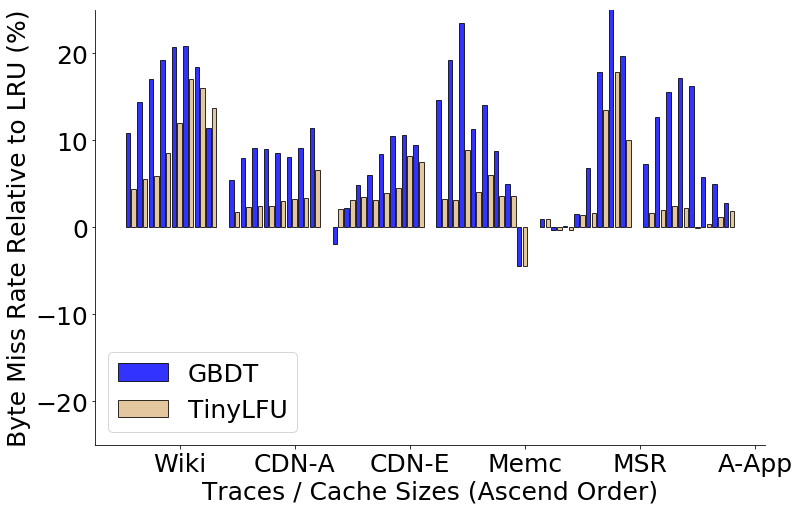

In [404]:
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.04
interval_bar = 0.01
interval_trace = 0.1
offsets_bar = np.arange(n_csizes)*(width+interval_bar)*2
offset_trace = 2*n_csizes*(interval_bar+width)+interval_trace

trace_names = (
    'wc400m.tr',
    'traceHK.tr',
    'traceUS.tr',
    'memc_200m.tr',
    'msr_rehash_200m.tr',
    'anonymous_200m.tr',
)
trace_labels = [trace_map[t] for t in trace_names]

for i, trace in enumerate(trace_names):
    grp = df2[df2.trace_file == trace]
    grp = grp.sort_values('cache_size')
    if i == 0:
        ax.bar(i*offset_trace+offsets_bar,
           grp.lru_reduction*100,
           width,
           color=color_map['GDBT'],
           edgecolor='k',
           alpha=0.8,
           label='GBDT')
    else: 
        ax.bar(i*offset_trace+offsets_bar,
           grp.lru_reduction*100,
           width,
           color=color_map['GDBT'],
           edgecolor='k',
           alpha=0.8)

for i, trace in enumerate(trace_names):
    grp = df2[df2.trace_file == trace]
    grp = grp.sort_values('cache_size')
    if i == 0:
        ax.bar(i*offset_trace+offsets_bar+interval_bar+width,
               grp.tlfu_reduction*100,
               width,
               color=color_map['Adaptive-TinyLFU'],
               edgecolor='k',
               alpha=0.8,
               label='TinyLFU')    
    else:
        ax.bar(i*offset_trace+offsets_bar+interval_bar+width,
               grp.tlfu_reduction*100,
               width,
               color=color_map['Adaptive-TinyLFU'],
               edgecolor='k',
               alpha=0.8)    

ax.set_xticks(np.arange(len(trace_names))+0.45)
ax.set_xticklabels(trace_labels) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Traces / Cache Sizes (Ascend Order)')
plt.ylabel('Byte Miss Rate Relative to LRU (%)')
plt.ylim([-25, 25])
plt.legend()
plt.savefig(f"{fig_dir}/evaluation_gbdt-tlfu_lru.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0)
# plt.title('GBDT')
plt.show()

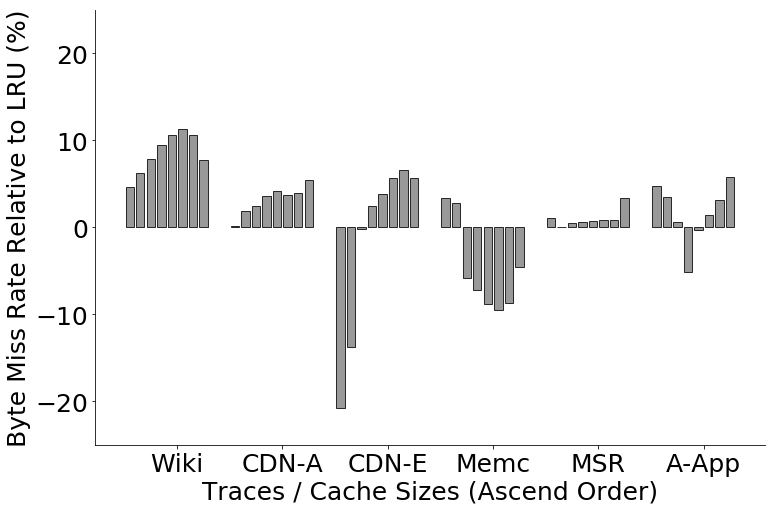

In [405]:
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.08
offsets = np.arange(n_csizes)*(width+0.02)

trace_names = (
    'wc400m.tr',
    'traceHK.tr',
    'traceUS.tr',
    'memc_200m.tr',
    'msr_rehash_200m.tr',
    'anonymous_200m.tr',
)
trace_labels = [trace_map[t] for t in trace_names]

for i, trace in enumerate(trace_names):
    grp = df2[df2.trace_file == trace]
    grp = grp.sort_values('cache_size')
    ax.bar(i+offsets,
           grp.lfuda_reduction*100,
           width,
           color=color_map['LFUDA'],
           edgecolor='k',
           alpha=0.8,
           label=trace)
    
ax.set_xticks(np.arange(len(trace_names))+0.45)
ax.set_xticklabels(trace_labels) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Traces / Cache Sizes (Ascend Order)')
plt.ylabel('Byte Miss Rate Relative to LRU (%)')
plt.ylim([-25, 25])
plt.savefig(f"{fig_dir}/evaluation_lfuda_lru.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0)
# plt.title('LFUDA')
plt.show()

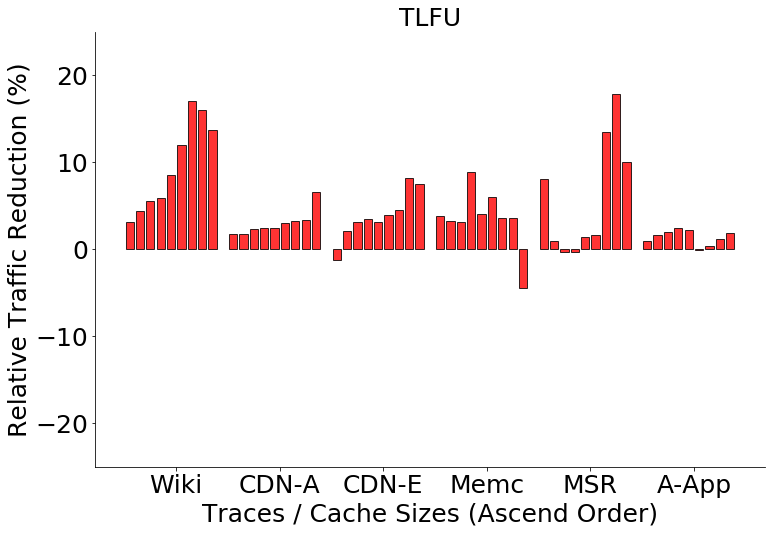

In [367]:
# fig, ax = plt.subplots(figsize=(12, 8))
# width = 0.08
# offsets = np.arange(9)*(width+0.02)

# trace_names = (
#     'wc400m.tr',
#     'traceHK.tr',
#     'traceUS.tr',
#     'memc_200m.tr',
#     'msr_rehash_200m.tr',
#     'anonymous_200m.tr',
# )
# trace_labels = [trace_map[t] for t in trace_names]

# for i, trace in enumerate(trace_names):
#     grp = df2[df2.trace_file == trace]
#     grp = grp.sort_values('cache_size')
#     ax.bar(i+offsets,
#            grp.tlfu_reduction*100,
#            width,
#            color='r',
#            edgecolor='k',
#            alpha=0.8,
#            label=trace)
    
# ax.set_xticks(np.arange(len(trace_names))+0.45)
# ax.set_xticklabels(trace_labels) 
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.xlabel('Traces / Cache Sizes (Ascend Order)')
# plt.ylabel('Relative Traffic Reduction (%)')
# plt.savefig(f"{fig_dir}/evaluation_relative_traffic_reduction.pdf",
#         bbox_inches = 'tight', 
#         pad_inches = 0)
# plt.ylim([-25, 25])
# plt.title('TLFU')
# plt.show()